In [7]:
import os

# Plotting and math imports
import numpy as np
from matplotlib import pyplot as plt

# File imports (used for generating animated graphs)
import imageio
import glob

# Misc imports
import pydot
from IPython.display import HTML, SVG, display

# Pydrake imports
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder,
                         GenerateHtml, InverseDynamicsController,
                         MeshcatVisualizer, MeshcatVisualizerParams,
                         MultibodyPlant, Parser, Simulator, StartMeshcat,
                         PidController, ModelVisualizer
)

test_mode = True if "TEST_SRCDIR" in os.environ else False

In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


## Make helper sdfs (floor)

In [3]:
floor_sdf = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="table_top">
    <link name="table_top_link">
      <visual name="visual">
        <pose>0 0 0 0 0 0</pose>
        <geometry>
          <box>
            <size>5.0 5.0 0.05</size>
          </box>
        </geometry>
        <material>
         <diffuse>0.9 0.8 0.7 1.0</diffuse>
        </material>
      </visual>
      <collision name="collision">
        <pose>0 0 0 0 0 0</pose>
        <geometry>
          <box>
            <size>5.0 5.0 0.05</size>
          </box>
        </geometry>
      </collision>
    </link>
    <frame name="table_top_center">
      <pose relative_to="table_top_link">0 0 0 0 0 0</pose>
    </frame>

    <joint name="world_to_table_joint" type="fixed">
      <parent>world</parent>
      <child>table_top_link</child>
      <pose>0 0 0 0 0 0</pose>
    </joint> 
  </model>
</sdf>"""

In [14]:
# Visualize the cylinder from the SDFormat string you just defined.
visualizer = ModelVisualizer(meshcat=meshcat)
visualizer.parser().AddModelFromFile("urdf/urdf/slider_2_0_urdf.urdf")
visualizer.parser().AddModelsFromString(floor_sdf, "sdf")

# Click the "Stop Running" button in MeshCat when you're finished.
visualizer.Run(loop_once=test_mode)

Click 'Stop Running' or press Esc to quit


<RunResult.STOPPED: 2>

## Create plant, import urdf and make context

In [78]:
builder = DiagramBuilder()

meshcat.Delete()
meshcat.DeleteAddedControls()

plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0002)

#null_gravity = [0, 0, 0,]
#plant.mutable_gravity_field().set_gravity_vector(null_gravity)

Parser(plant, scene_graph).AddModelFromFile("urdf/urdf/slider_2_0_urdf.urdf")
Parser(plant, scene_graph).AddModelsFromString(floor_sdf, 'sdf')
# plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
plant.Finalize()

visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

# Add a PID controller.
slide_transmission_ratio = 0.013
kp_leg = [100.0, 100.0, 10.0 / slide_transmission_ratio, 50.0, 50.0]
kd_leg = [3.0,   3.0,   1.0 / slide_transmission_ratio, 3.0, 3.0]

kp = np.append(kp_leg, kp_leg)
ki = np.ones(10) * 0.0
kd = np.append(kd_leg, kd_leg)

P_x = np.zeros((20, 33))
I_10 = np.identity(10)

P_x[0:10, 7:17] = I_10
P_x[10:20, 23:33] = I_10


# P_x = np.append(np.zeros((20, 13)), np.identity(20), axis=1)

controller = builder.AddNamedSystem("controller",
                                    PidController(kp=kp, ki=ki, kd=kd, state_projection = P_x))

builder.Connect(plant.get_state_output_port(),
            controller.get_input_port_estimated_state())
builder.Connect(controller.get_output_port_control(), plant.get_actuation_input_port())

builder.ExportInput(controller.get_input_port_desired_state())
builder.ExportOutput(controller.get_output_port_control())

# Build the diagram
diagram = builder.Build()

# Force publish to view the models we have spawned
context = diagram.CreateDefaultContext()
diagram.ForcedPublish(context)

#TODO: Fix floating body

## Print out default context and inspect block diagram

In [39]:
print(context)

# 33 states
# 13 states for body
# 10 states per leg x 2 = 20 states for legs

::_ Context
------------
Time: 0
States:
  1 discrete state groups with
     33 states
       1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Parameters:
  22 numeric parameter groups with
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
            2.43528   -0.0453876   4.1102e-09    0.0190139   0.00205883   0.00337163   0.00317352 -5.41884e-08  0.000861337  1.02605e-10
     10 parameters
            1.12926  -0.00651307 -0.000261818  7.57108e-06   0.00112826   0.00185161   0.00141115 -4.62621e-06  3.78722e-07 -9.60703e-07
     10 parameters
            1.06491   -0.0324497   -0.0178444  0.000925652   0.00198297   0.00279489   0.00216342 -0.000490573  4.00019e-05 -2.82059e-05
     10 parameters
            1.78099   -0.0233998  0.000112329     0.455008     0.230839     0.231852   0.00138431  3.12579e-06    0.0106454 -4.97924e-05
     10 parameters
          0.0383125  6.30628e-05  2.21613e-08 -1.27034e-08  0.000112848  0.00011409

In [43]:
# Test setting positions: we should have 17 positions:
# 4 body orientation
# 3 body position
# 5 joint position per leg
plant.SetPositions(context, [1, 0, 0, 0,
                             0, 0, 0,
                             0, 0, 0, 0, 0,
                             0, 0, 0, 0, 0])


# Test setting specific joint
print("num joints", plant.num_joints())
# Assuming the 11th joint is the floating base joint

plant.GetJointByName("Right_Roll").set_angle(context, 1.5)
print(context)


num joints 11
::_ Context
------------
Time: 0
States:
  1 discrete state groups with
     33 states
         1   0   0   0   0   0   0 1.5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Parameters:
  22 numeric parameter groups with
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
            2.43528   -0.0453876   4.1102e-09    0.0190139   0.00205883   0.00337163   0.00317352 -5.41884e-08  0.000861337  1.02605e-10
     10 parameters
            1.12926  -0.00651307 -0.000261818  7.57108e-06   0.00112826   0.00185161   0.00141115 -4.62621e-06  3.78722e-07 -9.60703e-07
     10 parameters
            1.06491   -0.0324497   -0.0178444  0.000925652   0.00198297   0.00279489   0.00216342 -0.000490573  4.00019e-05 -2.82059e-05
     10 parameters
            1.78099   -0.0233998  0.000112329     0.455008     0.230839     0.231852   0.00138431  3.12579e-06    0.0106454 -4.97924e-05
     10 parameters
   

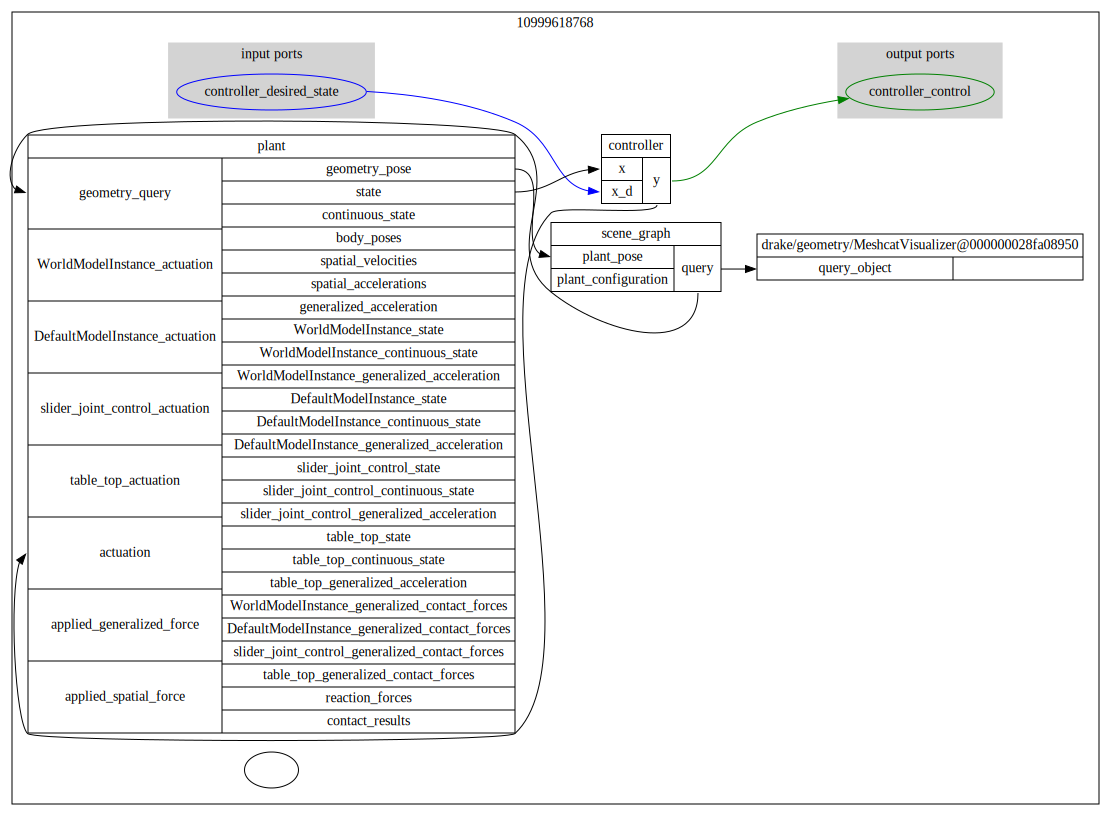

In [205]:
SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())

In [135]:
print("Num actuators", plant.num_actuators())
print("Num actuated dofs", plant.num_actuated_dofs())
print("Num positions", plant.num_positions())
print("Num velocities", plant.num_velocities())

Num actuators 10
Num actuated dofs 10
Num positions 17
Num velocities 16


## Set up actuators and initial conditions

In [83]:
def generate_new_sim_context():
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)

    # Zero out actuator forces for testing
    # T = np.zeros(10)
    #T[4] = 0.1
    # plant.get_actuation_input_port().FixValue(plant_context, T);

    # Set initial condition
    robot_height = 1.0 # meters
    plant.SetPositions(plant_context, [0.995, -0.1, 0.015, 0.004,
                                0.159, 0.191, 0.7166+0.1,
                                0.0, 0.0, 0.0, 0.0, 0.0,
                                0.0, 0.0, 0.0, 0.0, 0.0])
    
    plant.SetVelocities(plant_context, [0.0, 0.0, 0.0,
                                        0.0, 0.0, 0.0,
                                        0.0, 0.0, 0.0, 0.0, 0.0,
                                        0.0, 0.0, 0.0, 0.0, 0.0])
    
    # Set desired angle
    diagram.get_input_port(0).FixValue(context,np.append(np.zeros(10), np.zeros(10)))

    diagram.ForcedPublish(context)

    return context

context = generate_new_sim_context()
# print(context)

In [84]:
context = generate_new_sim_context()

simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(5.0)